Using device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 22.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 610kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.68MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.21MB/s]


Training samples: 60000
Test samples: 10000

Loading MNIST dataset and visualization

Class distribution in training set:
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64


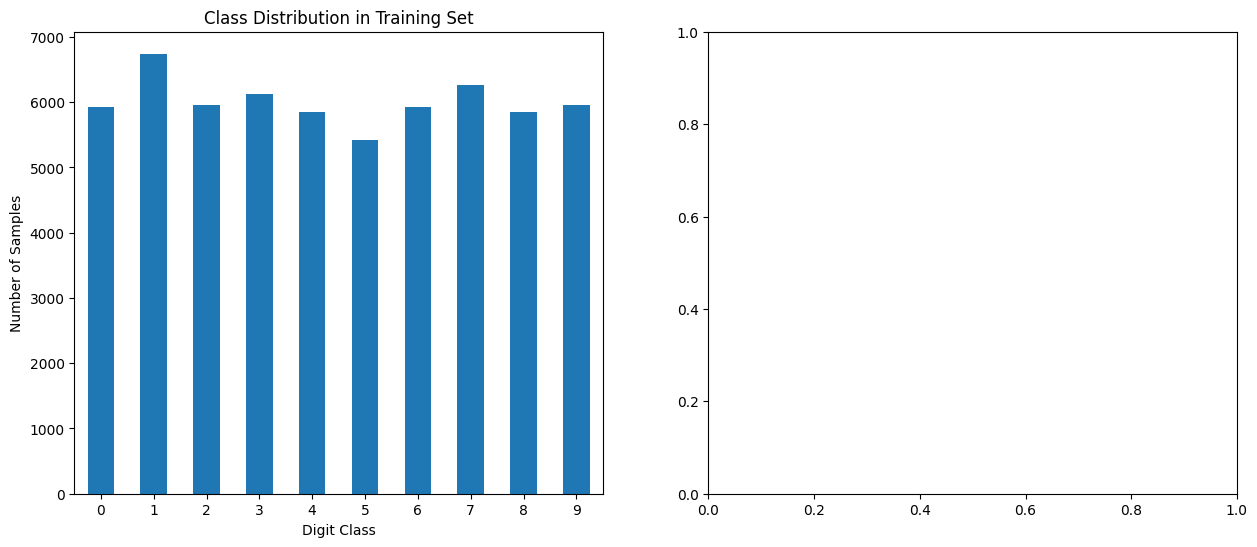

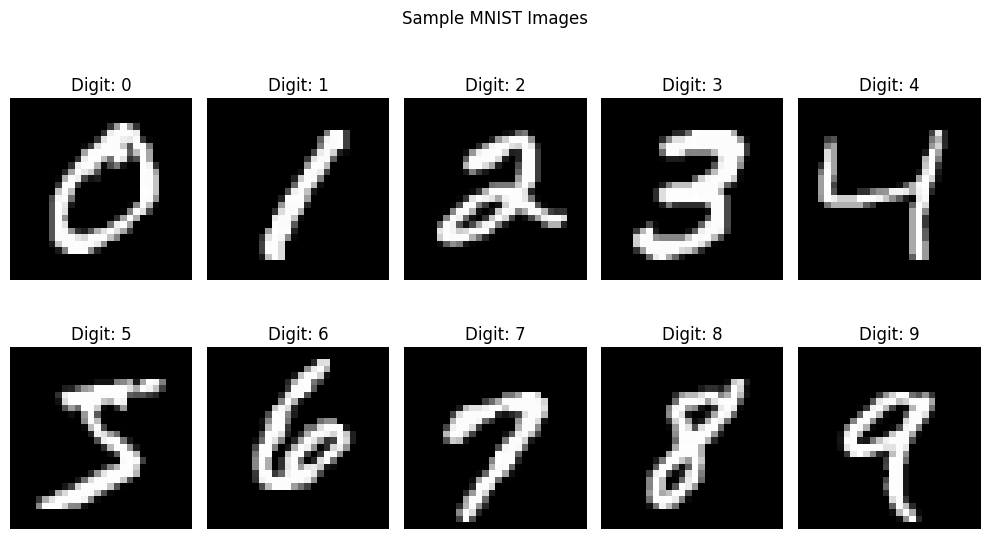


Model designing
Model Architecture:
MNISTCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc4): Linear(in_features=576, out_features=100, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc5): Linear(in_features=100, out_features=10, bias=True)
)

Total parameters: 213,270

Training the model

Epoch 1/10
------------------------------
Batch 0/469, Loss: 2.3026, Accuracy: 8.59%
Batch 100/469, Loss: 0.2312, Accuracy: 77.09%
Batch 200/469, Loss: 0.2592, Accuracy: 85.93%
Batch 300/469, Loss: 0.1464, Accuracy: 89.37%
Batch 400/469, Loss: 0.080

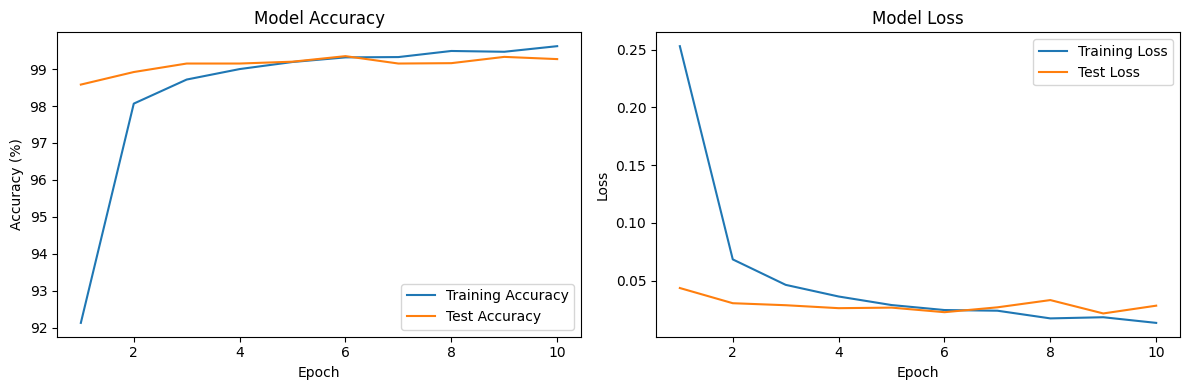


Testing the model
Final Test Loss: 0.0282
Final Test Accuracy: 99.27%


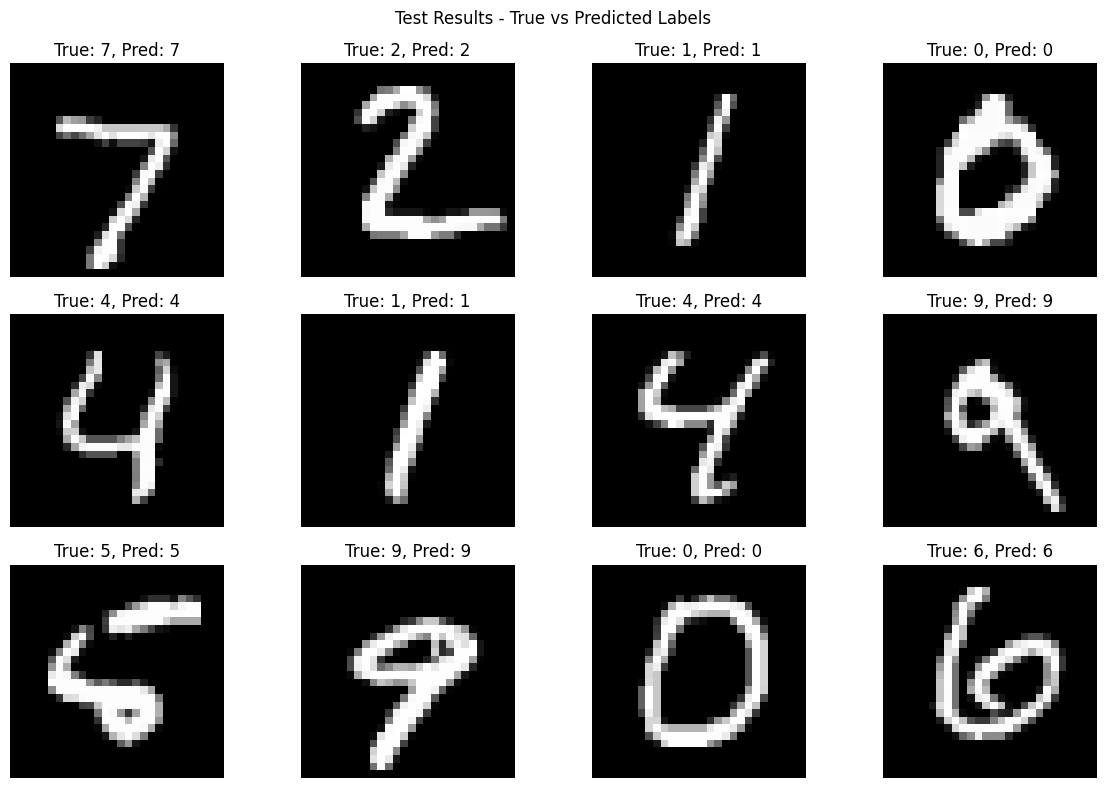

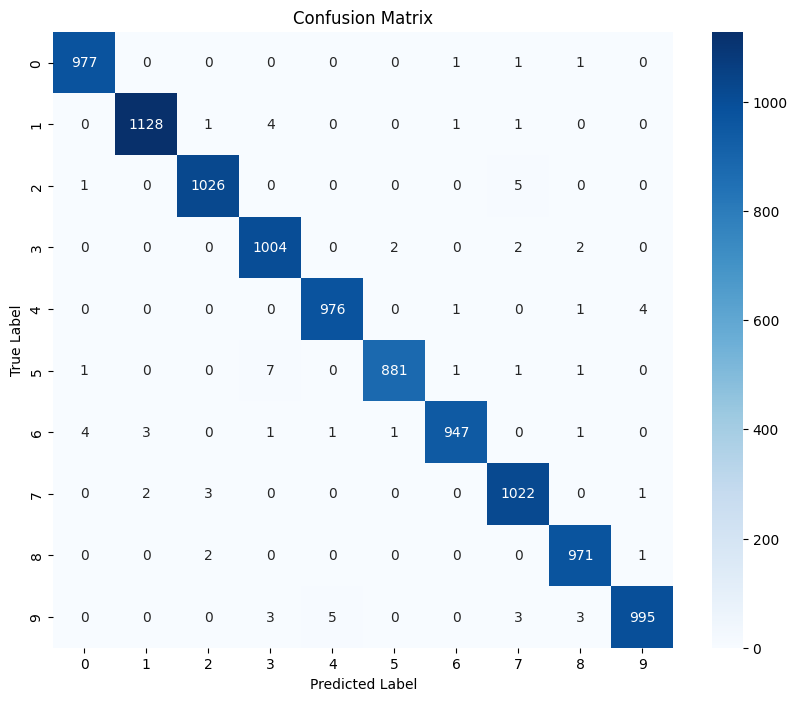


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      1.00      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


PyTorch CNN Implementation Complete!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from typing import Tuple, List, Dict
import numpy as np
import pandas as pd
from dataclasses import dataclass

@dataclass
class Config:
    batch_size: int = 128
    learning_rate: float = 0.001
    num_epochs: int = 10
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_dir: str = './data'
    mean: float = 0.1307
    std: float = 0.3081

class MNISTCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc4 = nn.Linear(64 * 3 * 3, 100)
        self.dropout = nn.Dropout(0.5)
        self.fc5 = nn.Linear(100, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x)
        return x

class DataHandler:
    def __init__(self, config: Config):
        self.config = config
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((config.mean,), (config.std,))
        ])
        self.raw_transform = transforms.ToTensor()

    def load_data(self) -> Tuple[DataLoader, DataLoader]:
        try:
            train_dataset = MNIST(root=self.config.data_dir, train=True,
                               download=True, transform=self.transform)
            test_dataset = MNIST(root=self.config.data_dir, train=False,
                              download=True, transform=self.transform)
            train_loader = DataLoader(train_dataset, batch_size=self.config.batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=self.config.batch_size, shuffle=False)
            return train_loader, test_loader
        except Exception as e:
            raise RuntimeError(f"Failed to load MNIST dataset: {str(e)}")

    def get_raw_dataset(self):
        return MNIST(root=self.config.data_dir, train=True,
                    download=False, transform=self.raw_transform)

class Visualization:
    @staticmethod
    def plot_class_distribution(train_dataset):
        train_labels = [label for _, label in train_dataset]
        class_distribution = pd.Series(train_labels).value_counts().sort_index()

        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        class_distribution.plot(kind='bar')
        plt.title('Class Distribution in Training Set')
        plt.xlabel('Digit Class')
        plt.ylabel('Number of Samples')
        plt.xticks(rotation=0)
        return class_distribution

    @staticmethod
    def plot_sample_images(raw_dataset):
        sample_indices = []
        for digit in range(10):
            for i, (_, label) in enumerate(raw_dataset):
                if label == digit:
                    sample_indices.append(i)
                    break

        plt.subplot(1, 2, 2)
        fig, axes = plt.subplots(2, 5, figsize=(10, 6))
        fig.suptitle('Sample MNIST Images')

        for i, idx in enumerate(sample_indices):
            row, col = i // 5, i % 5
            image, label = raw_dataset[idx]
            axes[row, col].imshow(image.squeeze(), cmap='gray')
            axes[row, col].set_title(f'Digit: {label}')
            axes[row, col].axis('off')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_training_history(train_metrics: Dict, test_metrics: Dict, num_epochs: int):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs+1), train_metrics['accuracy'], label='Training Accuracy')
        plt.plot(range(1, num_epochs+1), test_metrics['accuracy'], label='Test Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, num_epochs+1), train_metrics['loss'], label='Training Loss')
        plt.plot(range(1, num_epochs+1), test_metrics['loss'], label='Test Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_test_results(test_samples: List, test_labels: List, test_predictions: List, mean: float, std: float):
        plt.figure(figsize=(12, 8))
        for i in range(min(12, len(test_samples))):
            plt.subplot(3, 4, i + 1)
            img = test_samples[i].squeeze() * std + mean
            img = torch.clamp(img, 0, 1)
            plt.imshow(img, cmap='gray')
            plt.title(f'True: {test_labels[i]}, Pred: {test_predictions[i]}')
            plt.axis('off')
        plt.suptitle('Test Results - True vs Predicted Labels')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_confusion_matrix(true_labels: List, pred_labels: List):
        cm = confusion_matrix(true_labels, pred_labels)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=range(10), yticklabels=range(10))
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

class Trainer:
    def __init__(self, model: nn.Module, config: Config):
        self.model = model
        self.config = config
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        self.train_metrics = {'loss': [], 'accuracy': []}
        self.test_metrics = {'loss': [], 'accuracy': []}

    def train_epoch(self, train_loader: DataLoader) -> Tuple[float, float]:
        self.model.train()
        running_loss, correct, total = 0.0, 0, 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(self.config.device), target.to(self.config.device)
            self.optimizer.zero_grad()
            outputs = self.model(data)
            loss = self.criterion(outputs, target)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            if batch_idx % 100 == 0:
                print(f'Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}, '
                      f'Accuracy: {100.*correct/total:.2f}%')

        return running_loss / len(train_loader), 100. * correct / total

    def test(self, test_loader: DataLoader) -> Tuple[float, float]:
        self.model.eval()
        test_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.config.device), target.to(self.config.device)
                outputs = self.model(data)
                test_loss += self.criterion(outputs, target).item()
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        return test_loss / len(test_loader), 100. * correct / total

    def get_predictions(self, test_loader: DataLoader) -> Tuple[List, List]:
        self.model.eval()
        all_predictions, all_targets = [], []

        with torch.no_grad():
            for data, target in test_loader:
                data = data.to(self.config.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs, 1)
                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(target.numpy())

        return all_targets, all_predictions

    def get_test_samples(self, test_loader: DataLoader, max_samples: int = 12) -> Tuple[List, List, List]:
        self.model.eval()
        samples, labels, predictions = [], [], []

        with torch.no_grad():
            for data, target in test_loader:
                data = data.to(self.config.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs, 1)

                for j in range(min(max_samples - len(samples), data.size(0))):
                    samples.append(data[j].cpu())
                    labels.append(target[j].item())
                    predictions.append(predicted[j].cpu().item())

                if len(samples) >= max_samples:
                    break

        return samples, labels, predictions

def main():
    config = Config()
    print(f"Using device: {config.device}")

    # Data handling
    data_handler = DataHandler(config)
    train_loader, test_loader = data_handler.load_data()
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Test samples: {len(test_loader.dataset)}")

    # Visualize data
    print("\nLoading MNIST dataset and visualization")
    print("=" * 50)
    class_distribution = Visualization.plot_class_distribution(train_loader.dataset)
    print(f"\nClass distribution in training set:\n{class_distribution}")
    Visualization.plot_sample_images(data_handler.get_raw_dataset())

    # Model setup
    print("\nModel designing")
    print("=" * 50)
    model = MNISTCNN().to(config.device)
    print(f"Model Architecture:\n{model}")
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\nTotal parameters: {total_params:,}")

    # Training
    print("\nTraining the model")
    print("=" * 50)
    trainer = Trainer(model, config)

    for epoch in range(config.num_epochs):
        print(f'\nEpoch {epoch+1}/{config.num_epochs}')
        print('-' * 30)
        train_loss, train_acc = trainer.train_epoch(train_loader)
        test_loss, test_acc = trainer.test(test_loader)

        trainer.train_metrics['loss'].append(train_loss)
        trainer.train_metrics['accuracy'].append(train_acc)
        trainer.test_metrics['loss'].append(test_loss)
        trainer.test_metrics['accuracy'].append(test_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    # Visualize training history
    Visualization.plot_training_history(trainer.train_metrics, trainer.test_metrics, config.num_epochs)

    # Final evaluation
    print("\nTesting the model")
    print("=" * 50)
    final_test_loss, final_test_acc = trainer.test(test_loader)
    print(f"Final Test Loss: {final_test_loss:.4f}")
    print(f"Final Test Accuracy: {final_test_acc:.2f}%")

    # Visualize test results
    test_samples, test_labels, test_predictions = trainer.get_test_samples(test_loader)
    Visualization.plot_test_results(test_samples, test_labels, test_predictions, config.mean, config.std)

    # Confusion matrix and classification report
    true_labels, pred_labels = trainer.get_predictions(test_loader)
    Visualization.plot_confusion_matrix(true_labels, pred_labels)
    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels))

    print("\nPyTorch CNN Implementation Complete!")
    print("=" * 50)

if __name__ == "__main__":
    main()